In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm



from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
device

device(type='cuda')

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:

result = torch.tensor(np.where(mnist_trainset.targets != 3)[0])

#subset the dataset
data = torch.utils.data.Subset(mnist_trainset, result)
len(data)


53869

In [5]:
print('train_size', len(mnist_trainset))
print('test_size', len(mnist_testset)) 

train_size 60000
test_size 10000


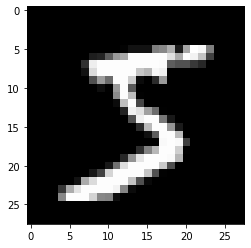

In [6]:
plt.imshow(mnist_trainset[0][0].numpy()[0], cmap='gray')

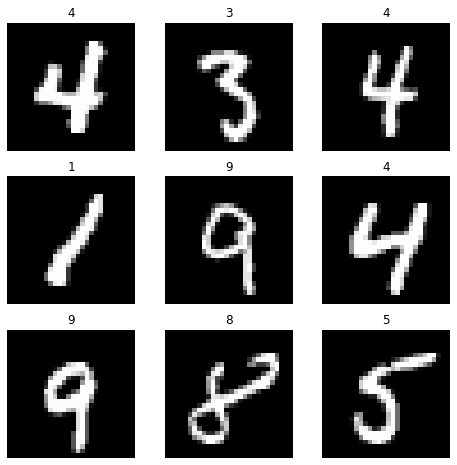

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_trainset), size=(1,)).item()
    img, label = mnist_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
train_dataloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mnist_testset, batch_size=10000, shuffle=True)
val_dataloader = DataLoader(mnist_testset, batch_size=10000, shuffle=True)
test_dataloader_not3 = DataLoader(data, batch_size=64, shuffle=True)



In [9]:
for batch_idx, (data, target) in enumerate(test_dataloader_not3):
  print(batch_idx)
  print(type(data))
  print(data.shape)
  print(target)
  break

0
<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
tensor([7, 7, 6, 1, 9, 7, 9, 6, 0, 8, 9, 4, 5, 0, 5, 4, 9, 5, 6, 1, 1, 8, 7, 4,
        8, 1, 8, 2, 8, 7, 6, 0, 6, 4, 0, 1, 0, 1, 9, 6, 8, 0, 9, 1, 8, 2, 1, 9,
        0, 0, 6, 4, 0, 7, 4, 0, 5, 6, 4, 8, 6, 6, 2, 9])


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


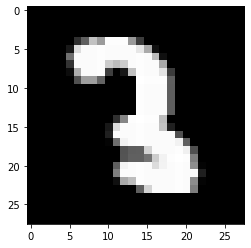

Label: 3


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[3].squeeze()
label = train_labels[3]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [18]:
class CNN(nn.Module):
    def __init__(self, name):
        super(CNN, self).__init__()
        self.name = name
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=4,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(4, 16, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out1 = nn.Linear(16 * 7 * 7, 10)
        self.out2 = nn.Linear(4 * 7 * 7, 10)
    def forward(self, x):
      if self.name == "teacher":
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out1(x)
        return output
      else:
        x = self.conv1(x)
        x = nn.MaxPool2d(kernel_size=2)(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out2(x)
        return output
    def get_name(self):
      return self.name

In [12]:
def softmax(input, t=1.0):
  ex = torch.exp(input/t)
  sum = torch.sum(ex, axis=1,keepdims=True)
  return ex / sum

In [13]:
def my_loss(output, target):
    loss = -torch.sum(target*torch.log(output))/len(output)
    return loss


In [19]:

model_ticher = CNN("teacher").to(device)
print(model_ticher)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ticher.parameters(), lr = 3e-4)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out1): Linear(in_features=784, out_features=10, bias=True)
  (out2): Linear(in_features=196, out_features=10, bias=True)
)


In [16]:
@torch.no_grad() # we do not need to save gradients during test
def calc_test(loader, model=None):
  for batch in tqdm(loader):
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    logit_batch_test = model.forward(X_batch)
    #print(self.logit_batch_test)
    logit_batch_test =F.softmax(logit_batch_test, 1).detach().cpu().numpy().argmax(axis=1).tolist() 
  return logit_batch_test, y_batch

def train_tich(train_loader, n_epochs, model_ticher, opt, criterion, device):
  a = []
  l = []
  model_ticher.train(True)
  epoch = 0
  for _epoch in range(n_epochs):
    ep_loss = []
    acc = []
    epoch += 1
    print(f"epoch {epoch:3d}/{n_epochs:3d} started")
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      opt.zero_grad()
      logits_tich = model_ticher.forward(data)
      loss = criterion(logits_tich, target)
      loss.backward()
      opt.step()
      ep_loss.append(loss.detach().cpu().numpy())
    lab=calc_test(val_dataloader,model_ticher)
    acc.append(accuracy_score(lab[0],lab[1]))
    print((f'[{epoch}] acc: {accuracy_score(lab[0],lab[1])}'))
    print((f'[{epoch}] loss: {np.mean(np.array(ep_loss))}'))
    a.append(accuracy_score(lab[0],lab[1]))
    l.append(np.mean(np.array(ep_loss)))
  plt.plot(a, label = "acc")
  plt.plot(l, label = "loss")

  

epoch   1/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[1] acc: 0.9569
[1] loss: 0.431281715631485
epoch   2/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[2] acc: 0.9694
[2] loss: 0.12548403441905975
epoch   3/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[3] acc: 0.977
[3] loss: 0.09086403250694275
epoch   4/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[4] acc: 0.9804
[4] loss: 0.0750211551785469
epoch   5/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[5] acc: 0.9817
[5] loss: 0.06470046937465668
epoch   6/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[6] acc: 0.9838
[6] loss: 0.05797940492630005
epoch   7/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[7] acc: 0.9847
[7] loss: 0.05271138995885849
epoch   8/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[8] acc: 0.9852
[8] loss: 0.04788065701723099
epoch   9/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[9] acc: 0.9838
[9] loss: 0.04447728767991066
epoch  10/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[10] acc: 0.9855
[10] loss: 0.040251947939395905
epoch  11/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[11] acc: 0.9857
[11] loss: 0.038764383643865585
epoch  12/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[12] acc: 0.9865
[12] loss: 0.03557703644037247
epoch  13/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[13] acc: 0.9879
[13] loss: 0.03390071168541908
epoch  14/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[14] acc: 0.9857
[14] loss: 0.03190247714519501
epoch  15/ 15 started


  0%|          | 0/1 [00:00<?, ?it/s]

[15] acc: 0.9875
[15] loss: 0.029610656201839447


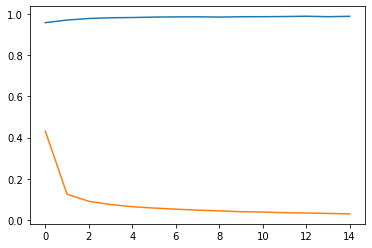

In [20]:
train_tich(train_dataloader, 15, model_ticher,optimizer,criterion,device)
torch.save(model_ticher.state_dict(),'model_ticher.ckpt')

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out1): Linear(in_features=784, out_features=10, bias=True)
  (out2): Linear(in_features=196, out_features=10, bias=True)
)
cuda
epoch   1/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[1] acc: 0.9275
[1] loss: 0.7160994410514832
epoch   2/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[2] acc: 0.9483
[2] loss: 0.2301187813282013
epoch   3/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[3] acc: 0.9587
[3] loss: 0.17304563522338867
epoch   4/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[4] acc: 0.9636
[4] loss: 0.14569993317127228
epoch   5/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[5] acc: 0.9658
[5] loss: 0.12971216440200806
epoch   6/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[6] acc: 0.9679
[6] loss: 0.11891429871320724
epoch   7/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[7] acc: 0.9682
[7] loss: 0.11090578138828278
epoch   8/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[8] acc: 0.97
[8] loss: 0.1046924740076065
epoch   9/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[9] acc: 0.9717
[9] loss: 0.10047634690999985
epoch  10/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[10] acc: 0.9716
[10] loss: 0.0966232568025589


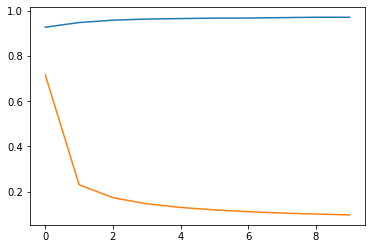

In [21]:
model_student = CNN("student").to(device)
print(model_student)
print(device)
criterion = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_student.parameters(), lr = 3e-4)

train_tich(train_dataloader, 10, model_student,optimizer_2,criterion,device)
torch.save(model_student.state_dict(),'model_stud.ckpt')




In [22]:
def train_stud(train_loader, n_epochs, model_ticher, model_student,opt, device,T):
  model_student.train(True)
  model_ticher.train(False)
  epoch = 0
  for _epoch in range(n_epochs):
    ep_loss = []
    acc = []
    epoch += 1
    print(f"epoch {epoch:3d}/{n_epochs:3d} started")
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      opt.zero_grad()
      logits_tich = model_ticher(data)
      logits_student = model_student(data)
      p_st = softmax(logits_student, T)
      p_tich = softmax(logits_tich, T) 
      loss = my_loss(p_st, p_tich)
      loss.backward()
      opt.step()
      ep_loss.append(loss.detach().cpu().numpy())
    lab=calc_test(val_dataloader,model_student)
    acc.append(accuracy_score(lab[0],lab[1]))
    print((f'[{epoch}] acc: {accuracy_score(lab[0],lab[1])}'))
    print((f'[{epoch}] loss: {np.mean(np.array(ep_loss))}'))

  

In [31]:
model_stud_dist = CNN("stud_dist").to(device)
print(device)
optimizer_stud_dist = optim.Adam(model_stud_dist.parameters(), lr = 3e-4)


cuda


In [32]:
train_stud(train_dataloader, 10, model_ticher, model_stud_dist,optimizer_stud_dist,device,5)
torch.save(model_stud_dist.state_dict(),'model_stud_dist_t3.ckpt')

epoch   1/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[1] acc: 0.9087
[1] loss: 1.5933811664581299
epoch   2/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[2] acc: 0.9334
[2] loss: 1.245876669883728
epoch   3/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[3] acc: 0.9495
[3] loss: 1.2046442031860352
epoch   4/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[4] acc: 0.9553
[4] loss: 1.18424391746521
epoch   5/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[5] acc: 0.9601
[5] loss: 1.1724375486373901
epoch   6/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[6] acc: 0.9617
[6] loss: 1.1653419733047485
epoch   7/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[7] acc: 0.9639
[7] loss: 1.1611294746398926
epoch   8/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[8] acc: 0.9655
[8] loss: 1.1584118604660034
epoch   9/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[9] acc: 0.9653
[9] loss: 1.1567131280899048
epoch  10/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[10] acc: 0.9658
[10] loss: 1.1554324626922607


In [34]:

model_stud_dist_t2 = CNN("ss").to(device)



#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#model_stud = Net().to(device)
optimizer_4 = optim.Adam(model_stud_dist_t2.parameters(), lr = 3e-4)
criterion_4 = nn.CrossEntropyLoss()


train_stud(test_dataloader_not3, 10, model_ticher, model_stud_dist_t2,optimizer_4,device,5)
torch.save(model_stud_dist_t2.state_dict(),'model_stud_dist_t2.ckpt')



epoch   1/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[1] acc: 0.8177
[1] loss: 1.6139774322509766
epoch   2/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[2] acc: 0.8529
[2] loss: 1.2498513460159302
epoch   3/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[3] acc: 0.8777
[3] loss: 1.2063162326812744
epoch   4/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[4] acc: 0.8954
[4] loss: 1.1844985485076904
epoch   5/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[5] acc: 0.912
[5] loss: 1.1723449230194092
epoch   6/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[6] acc: 0.9184
[6] loss: 1.1652055978775024
epoch   7/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[7] acc: 0.9248
[7] loss: 1.1607364416122437
epoch   8/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[8] acc: 0.9301
[8] loss: 1.1578519344329834
epoch   9/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[9] acc: 0.9361
[9] loss: 1.1559187173843384
epoch  10/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[10] acc: 0.9381
[10] loss: 1.1544599533081055


epoch   1/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[1] acc: 0.8299
[1] loss: 0.7405605912208557
epoch   2/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[2] acc: 0.8513
[2] loss: 0.24149014055728912
epoch   3/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[3] acc: 0.8596
[3] loss: 0.17699451744556427
epoch   4/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[4] acc: 0.8637
[4] loss: 0.14519666135311127
epoch   5/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[5] acc: 0.8655
[5] loss: 0.1256198137998581
epoch   6/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[6] acc: 0.8691
[6] loss: 0.11231075972318649
epoch   7/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[7] acc: 0.8738
[7] loss: 0.10312672704458237
epoch   8/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[8] acc: 0.8733
[8] loss: 0.09609146416187286
epoch   9/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[9] acc: 0.8755
[9] loss: 0.09050299227237701
epoch  10/ 10 started


  0%|          | 0/1 [00:00<?, ?it/s]

[10] acc: 0.8757
[10] loss: 0.08613000810146332


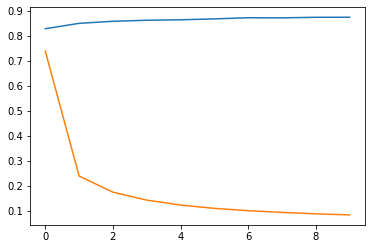

In [35]:
model_stud_without_tich = CNN("ss").to(device)
optimizer_4 = optim.Adam(model_stud_without_tich.parameters(), lr = 3e-4)
criterion_4 = nn.CrossEntropyLoss()


train_tich(test_dataloader_not3, 10, model_stud_without_tich,optimizer_4,criterion_4,device)
torch.save(model_ticher.state_dict(),'model_ticher.ckpt')

In [ ]:
model_stud_without_tich

  0%|          | 0/1 [00:00<?, ?it/s]

[] acc: 0.8402


In [ ]:
model_stud_dist_t2

In [47]:

data_3 = torch.tensor(np.where(mnist_testset.targets == 3)[0])

#subset the dataset
data_3 = torch.utils.data.Subset(mnist_testset, data_3)
data_3

In [48]:
dt3 = DataLoader(data_3, batch_size=len(data_3), shuffle=True)


In [50]:
for batch_idx, (data, target) in enumerate(dt3):
      data, target = data.to(device), target.to(device)
      logits_student_dist = model_stud_dist_t2(data)
      logits_student = model_stud_without_tich(data)

In [64]:
logits_student_dist.mean(dim=0)

tensor([ -7.7021,  -8.8384,  -0.6809,   7.9559, -14.7093,   4.9083, -15.7937,
         -4.5731,   1.9340,   0.8917], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [62]:
logits_student.mean(dim=0)

tensor([ -7.0781,  -6.7837,   0.1907, -19.5683, -11.1176,   2.4382, -10.5467,
         -5.0733,   0.2593,  -1.6085], device='cuda:0',
       grad_fn=<MeanBackward1>)